# Executive Summary
The objective of this project is to analyze TTC bus delay data to determine the relationship between number of delays, day of the week, and hour of the day throughout 2022. Data is sourced from the City of Toronto's Open Data page, with further data collected through webscraping on Wikipedia.

A simple polynomial regression model is also created to predict the number of delays throughout the day on a Friday in 2022, with up to 70% accuracy.

## Summary Statistics
1. Most delays throughout the week happen on Friday, with the least delays consistently on Sunday. The peak number of delays happen between 2PM and 5PM throughout the week -- right before the expected rush hour on business days.
2. Each day of the week generally follows the same distribution of number of delays throughout the hours of the day, with peak delays at 5AM and 2 to 5PM. A covariance matrix suggests that the number of delays between the latter time range have a strong relation to each other.
3. A polynomial regression model can adequately model Friday delays throughout the day, but further recommendations are made to increase complexity and accuracy of the model.

In [272]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup 

import seaborn as sns
import matplotlib.pyplot as plt

In [273]:
# Loading data
bus_data = pd.read_csv('ttc-bus-delay-data-2022.csv')
print(bus_data.shape)
bus_data.head()

(27351, 10)


,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,1-Jan-22,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,NaN,8531
1,1-Jan-22,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,W,8658
2,1-Jan-22,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,S,0
3,1-Jan-22,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,S,0
4,1-Jan-22,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,S,0


## Data Cleaning

In [274]:
# Look for null values
bus_data.isnull().sum()

Date            0
Route         164
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Direction    5577
Vehicle         0
dtype: int64

In [275]:
# The direction column provides the direction that the vehicle is travelling, which is trivial for the objection of this project, so it can be dropped.

bus_data = bus_data.drop(['Direction'], axis=1)

In [276]:
nan_routes = bus_data[bus_data['Route'].isna()]
print(nan_routes)

            Date Route   Time        Day                Location  \
369     3-Jan-22   NaN  08:50     Monday      MCCAUL AND BALDWIN   
382     3-Jan-22   NaN  09:51     Monday         MCNICOLL GARAGE   
910     5-Jan-22   NaN  12:24  Wednesday  1411 LAWRENCE AVE WEST   
1623    7-Jan-22   NaN  20:09     Friday           WILSON GARAGE   
2089   10-Jan-22   NaN  17:40     Monday      FINCH WEST STATION   
...          ...   ...    ...        ...                     ...   
26102  22-Jun-22   NaN  19:28  Wednesday         KIPLING STATION   
26288  23-Jun-22   NaN  21:51   Thursday       BIRCHMOUNT GARAGE   
26634  27-Jun-22   NaN  05:07     Monday     MOUNT DENNIS GARAGE   
26999  29-Jun-22   NaN  10:06  Wednesday       HILLCREST COMPLEX   
27039  29-Jun-22   NaN  14:03  Wednesday     BIRCHMOUNT DIVISION   

                    Incident  Min Delay  Min Gap  Vehicle  
369       Utilized Off Route          0        0        0  
382    Operations - Operator          0        0        0  
910

In [277]:
# The route column cannot be dropped as it will provide valuable information later in the analysis. Instead, 
# we can delete an entry where the route is NaN, as there are only 164 instances of this compared 
# to dataset size of 22,000+.

bus_data = bus_data.dropna(subset=['Route'])
bus_data.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Vehicle
0,1-Jan-22,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,8531
1,1-Jan-22,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,8658
2,1-Jan-22,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,0
3,1-Jan-22,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,0
4,1-Jan-22,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,0


In [278]:
# The route number is not very descriptive, so we can create a new column that has the name of the route
# to enrich the data.
# The route name can be pulled from the TTC Routes and Schedules dataset

schedule = pd.read_csv('./opendata_ttc_schedules/routes.txt', delimiter=',')
schedule.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,69055,1,1,LINE 1 (YONGE-UNIVERSITY),NaN,1,NaN,D5C82B,000000
1,68844,1,10,VAN HORNE,NaN,3,NaN,FF0000,FFFFFF
2,68845,1,100,FLEMINGDON PARK,NaN,3,NaN,FF0000,FFFFFF
3,68846,1,101,DOWNSVIEW PARK,NaN,3,NaN,FF0000,FFFFFF
4,68847,1,102,MARKHAM RD.,NaN,3,NaN,FF0000,FFFFFF


In [279]:
# Clean dataframe
schedule = schedule.loc[:,['route_short_name', 'route_long_name']]
schedule.index = schedule.index + 1
schedule = schedule.rename(columns={'route_short_name': 'Route', 'route_long_name': 'Route Name'})
print(schedule)

     Route                 Route Name
1        1  LINE 1 (YONGE-UNIVERSITY)
2       10                  VAN HORNE
3      100            FLEMINGDON PARK
4      101             DOWNSVIEW PARK
5      102                MARKHAM RD.
..     ...                        ...
205    986        SCARBOROUGH EXPRESS
206    989             WESTON EXPRESS
207     99                 ARROW ROAD
208    995         YORK MILLS EXPRESS
209    996             WILSON EXPRESS

[209 rows x 2 columns]


In [280]:
# Look for null values
schedule.isnull().sum()

Route         0
Route Name    0
dtype: int64

In [281]:
# Now, we can map route_long_name to route using route_short_name

bus_data['Route'] = bus_data['Route'].astype(str)
schedule['Route'] = schedule['Route'].astype(str)

# Merge the two DataFrames based on 'Route'
bus_data = pd.merge(bus_data, schedule, how='left', on='Route')
# Check the merged DataFrame
bus_data.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Vehicle,Route Name
0,1-Jan-22,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,8531,YONGE NIGHT BUS
1,1-Jan-22,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,8658,DON MILLS NIGHT BUS
2,1-Jan-22,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,0,YONGE NIGHT BUS
3,1-Jan-22,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,0,YONGE NIGHT BUS
4,1-Jan-22,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,0,YONGE NIGHT BUS


In [282]:
# Look for unfilled data
bus_data.isnull().sum()

Date            0
Route           0
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Vehicle         0
Route Name    260
dtype: int64

In [283]:
nan_route_names = bus_data[bus_data['Route Name'].isna()]
print(nan_route_names) 

# The data is not critically dependent on having a Route Name, since they can still be identified with its route number. We will leave the NA's in the dataset.

            Date Route   Time       Day                Location  \
275     3-Jan-22   999  02:06    Monday        QUEENSWAY GARAGE   
520     3-Jan-22   600  17:52    Monday      YORK MILLS STATION   
551     3-Jan-22   999  23:30    Monday           1828 O'CONNOR   
555     4-Jan-22   600  02:00   Tuesday         EXHIBITION LOOP   
760     4-Jan-22   999  19:46   Tuesday             828 SHAW ST   
...          ...   ...    ...       ...                     ...   
26345  25-Jun-22   172  16:58  Saturday  CHERRY ST AND CHERRY L   
26467  26-Jun-22   999  01:40    Sunday           WILSON GARAGE   
26583  27-Jun-22   999  19:37    Monday            ARROW GARAGE   
27041  30-Jun-22   172  12:22  Thursday   LAKE SHORE AND CHERRY   
27044  30-Jun-22   172  12:34  Thursday    CHERRY AND LAKESHORE   

                               Incident  Min Delay  Min Gap  Vehicle  \
275                     Collision - TTC          0        0     3354   
520                     Collision - TTC          0 

In [284]:
# To further add to the dataset, we can pull more information about the fleet vehicle using another web scraper, saved in: ttc_scraper.ipnyb

# Import the resulting pickle file

vehicle_data = pd.read_pickle('ttc_fleet.pkl')
vehicle_data.rename(columns={'Fleet number': 'Vehicle'}, inplace = True)
vehicle_data.head()

,Vehicle,Year,Manufacturer,Model,Engine,Transmission,Destination sign,Seating
0,1000.0,2006,OBI - DCCBNA,07.501 HEV,Cummins ISB,BAE Systems HybriDrive hybrid system,Luminator Horizon,38 American Seating Model 6468
1,1001.0,2006,OBI - DCCBNA,07.501 HEV,Cummins ISB,BAE Systems HybriDrive hybrid system,Luminator Horizon,38 American Seating Model 6468
2,1002.0,2006,OBI - DCCBNA,07.501 HEV,Cummins ISB,BAE Systems HybriDrive hybrid system,Luminator Horizon,38 American Seating Model 6468
3,1003.0,2006,OBI - DCCBNA,07.501 HEV,Cummins ISB,BAE Systems HybriDrive hybrid system,Luminator Horizon,38 American Seating Model 6468
4,1004.0,2006,OBI - DCCBNA,07.501 HEV,Cummins ISB,BAE Systems HybriDrive hybrid system,Luminator Horizon,38 American Seating Model 6468


In [285]:
# Merge the two DataFrames based on 'Route'
bus_data = pd.merge(bus_data, vehicle_data, how='left', on='Vehicle')
# Check the merged DataFrame
bus_data.head()

# The data is not critically dependent on having fleet details, since they can still
# be identified with its vehicle number. We will leave the NA's in the dataset, and further
# clean the data later on if the need arises.

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Vehicle,Route Name,Year,Manufacturer,Model,Engine,Transmission,Destination sign,Seating
0,1-Jan-22,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,8531,YONGE NIGHT BUS,2016,Nova Bus,LFS,Cummins ISL9,Allison B400R,Luminator Horizon,"6 American Seating 6468, 27 American Seating ..."
1,1-Jan-22,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,8658,DON MILLS NIGHT BUS,2017,Nova Bus,LFS,Cummins L9,Allison B400R,Luminator Horizon,"6 American Seating 6468, 27 American Seating ..."
2,1-Jan-22,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,0,YONGE NIGHT BUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1-Jan-22,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,0,YONGE NIGHT BUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1-Jan-22,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,0,YONGE NIGHT BUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Analysis
Now, we can begin exploring the data and statistical features within the set.

In [286]:
bus_data.shape

(27187, 17)

In [287]:
bus_data.describe(include='all')

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Vehicle,Route Name,Year,Manufacturer,Model,Engine,Transmission,Destination sign,Seating
count,27187,27187,27187,27187,27187,27187,27187.000000,27187.000000,27187.000000,26927,23772,23772,23772,23772,23772,23772,23770
unique,181,223,1440,7,5878,15,NaN,NaN,NaN,194,16,6,13,8,8,1,11
top,5-Jan-22,36,16:00,Friday,KIPLING STATION,Operations - Operator,NaN,NaN,NaN,FINCH WEST,2017,Nova Bus,LFS,Cummins L9,Allison B400R,Luminator Horizon,36 American Seating 6468
freq,297,971,87,4495,623,9532,NaN,NaN,NaN,971,3550,13725,8981,6469,10646,23772,6149
mean,NaN,NaN,NaN,NaN,NaN,NaN,20.365175,33.008019,5420.757421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,49.508103,51.146846,4599.078176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,17.000000,1398.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,22.000000,7943.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,37.000000,8524.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To make these indicators more meaningful for the project hypothesis, we can aggregate the dataset by date and time and visualize the results.

In [288]:
delay_by_day = bus_data['Day'].value_counts().to_frame()
delay_by_day.reset_index(inplace=True)

delay_by_day.columns = ['Day', 'Count of Delays']

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
delay_by_day_sorted = delay_by_day.sort_values(by='Day', key=lambda x: pd.Categorical(x, categories=week_order, ordered=True))


print(delay_by_day_sorted)

delay_by_time = bus_data['Time'].value_counts().to_frame()
delay_by_time.reset_index(inplace=True)

delay_by_time.columns = ['Time', 'Count of Delays']
delay_by_time['Time'] = pd.to_datetime(delay_by_time['Time'])


delay_by_time = delay_by_time.groupby(pd.Grouper(key='Time', freq='H')).sum()

delay_by_time = delay_by_time.reset_index()
delay_by_time['Time'] = delay_by_time['Time'].dt.strftime('%H:%M')
print(delay_by_time)

         Day  Count of Delays
4     Monday             4009
3    Tuesday             4070
1  Wednesday             4340
2   Thursday             4338
0     Friday             4495
5   Saturday             3468
6     Sunday             2467
     Time  Count of Delays
0   00:00              502
1   01:00              450
2   02:00              453
3   03:00              297
4   04:00              436
5   05:00             1248
6   06:00             1577
7   07:00             1095
8   08:00             1050
9   09:00             1188
10  10:00             1051
11  11:00             1006
12  12:00             1246
13  13:00             1624
14  14:00             2096
15  15:00             2032
16  16:00             1973
17  17:00             1934
18  18:00             1577
19  19:00             1134
20  20:00              958
21  21:00              941
22  22:00              694
23  23:00              625


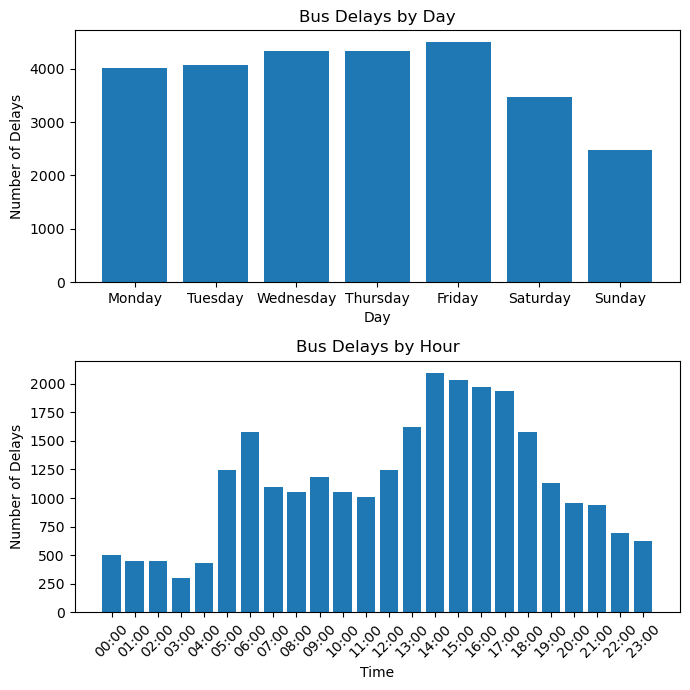

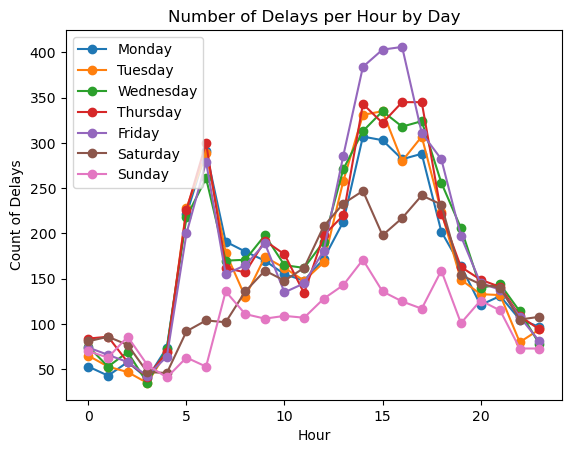

In [423]:
fig, axs = plt.subplots(2,1,figsize=(7,7))

axs[0].bar(delay_by_day_sorted['Day'], delay_by_day_sorted['Count of Delays'])
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Number of Delays')
axs[0].set_title('Bus Delays by Day')

axs[1].bar(delay_by_time['Time'], delay_by_time['Count of Delays'])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Number of Delays')
axs[1].set_title('Bus Delays by Hour')
axs[1].set_xticks(delay_by_time['Time'])
axs[1].set_xticklabels(delay_by_time['Time'], rotation=45)

plt.tight_layout()
plt.show()

# Now, visualize the data by time for each day of the week

# Extract the hour from the 'Time' column
bus_data['Hour'] = pd.to_datetime(bus_data['Time']).dt.hour

# Compute the count of delays per hour by day
delays_per_hour = bus_data.groupby(['Hour', 'Day']).size().unstack()
delays_per_hour = delays_per_hour.reindex(columns=week_order)

# Plot the data
delays_per_hour.plot(kind='line',marker='o')
plt.xlabel('Hour')
plt.ylabel('Count of Delays')
plt.title('Number of Delays per Hour by Day')
plt.legend()

plt.show()
# print(delays_per_hour)

In the Bus Delays by Day graph, we can observe that most delays throughout the week happen on Friday, with the least delays on Sunday. The delay count throughout the weekdays are relatively consistent, which align with a more frequent bus schedule on business days over weekends.

In the Bus Delays by Hour graph, the peak number of delays happen between 2PM and 5PM throughout the week -- right before the expected rush hour on business days.

When aggregating this data to see the count of delays per hour per day in the third graph, we can see that each day follows generally the same distribution or shape throughout the hours of the day, with peak delays at 5AM and 2 to 5PM. Again, the delays on weekends are notably lower to that on weekdays.

In [290]:
delays_per_hour.describe()

Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,167.041667,169.583333,180.833333,180.750000,187.291667,144.500000,102.791667
std,84.974410,93.214067,92.076370,94.179408,111.107656,62.093198,35.306089
min,40.000000,35.000000,35.000000,42.000000,43.000000,46.000000,41.000000
25%,103.000000,90.500000,105.000000,105.250000,101.250000,99.500000,72.250000
50%,167.000000,155.500000,170.500000,162.500000,160.000000,142.000000,108.000000
75%,215.000000,235.500000,257.250000,223.000000,279.750000,200.500000,126.500000
max,307.000000,335.000000,335.000000,345.000000,406.000000,247.000000,171.000000


Now, we can explore the covariances and correlations between days and hours.

Text(0.5, 1.0, 'Covariance Matrix of Delays per Day')

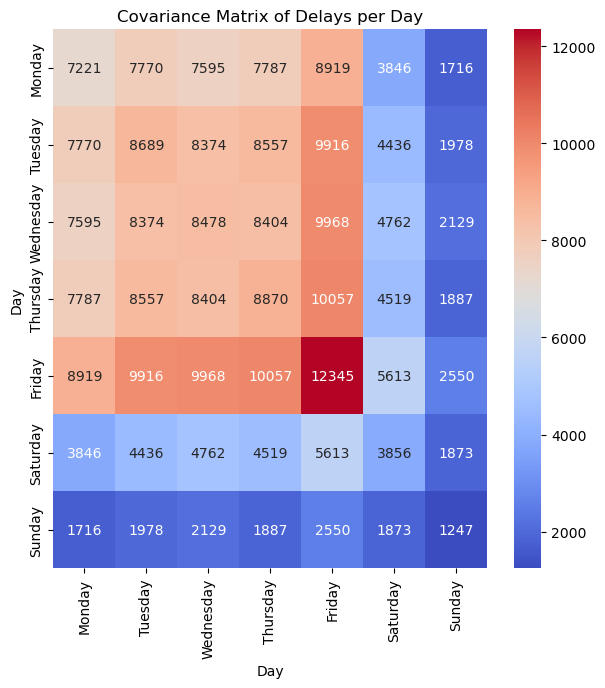

In [291]:
delays_per_hour_cov = delays_per_hour.cov()
plt.figure(figsize=(7, 7))
sns.heatmap(delays_per_hour_cov, annot=True, fmt='.0f', cmap='coolwarm')
plt.title('Covariance Matrix of Delays per Day')

The above covariance matrix shows that there are generally low covariances between any given day of the week and a weekend day. In other words, the number of delays on a given day does not notably impact the number of delays on a weekend. On the Saturday/Sunday diagonals, there are low variances, which means that the number of delays on Saturday and Sunday are less scatterd and have less variability throughout the year.

On the other hand, the weekdays show a high covariance between each other, which indicates a stronger relationship between the number of delays on one day to the number of delays on another day (e.g. delay count on Thursday impacts the delay count on Friday) (but does not necessarily mean causation). However, on the weekday diagonals, there is a high variance, meaning that the delay count vary much more throughout the year (i.e. number of delays are more scattered).

In [292]:
delays_per_hour_transposed = delays_per_hour.transpose()
delays_per_hour_transposed_cov = delays_per_hour_transposed.cov()

Text(0.5, 1.0, 'Covariance Matrix of Delays per Hour')

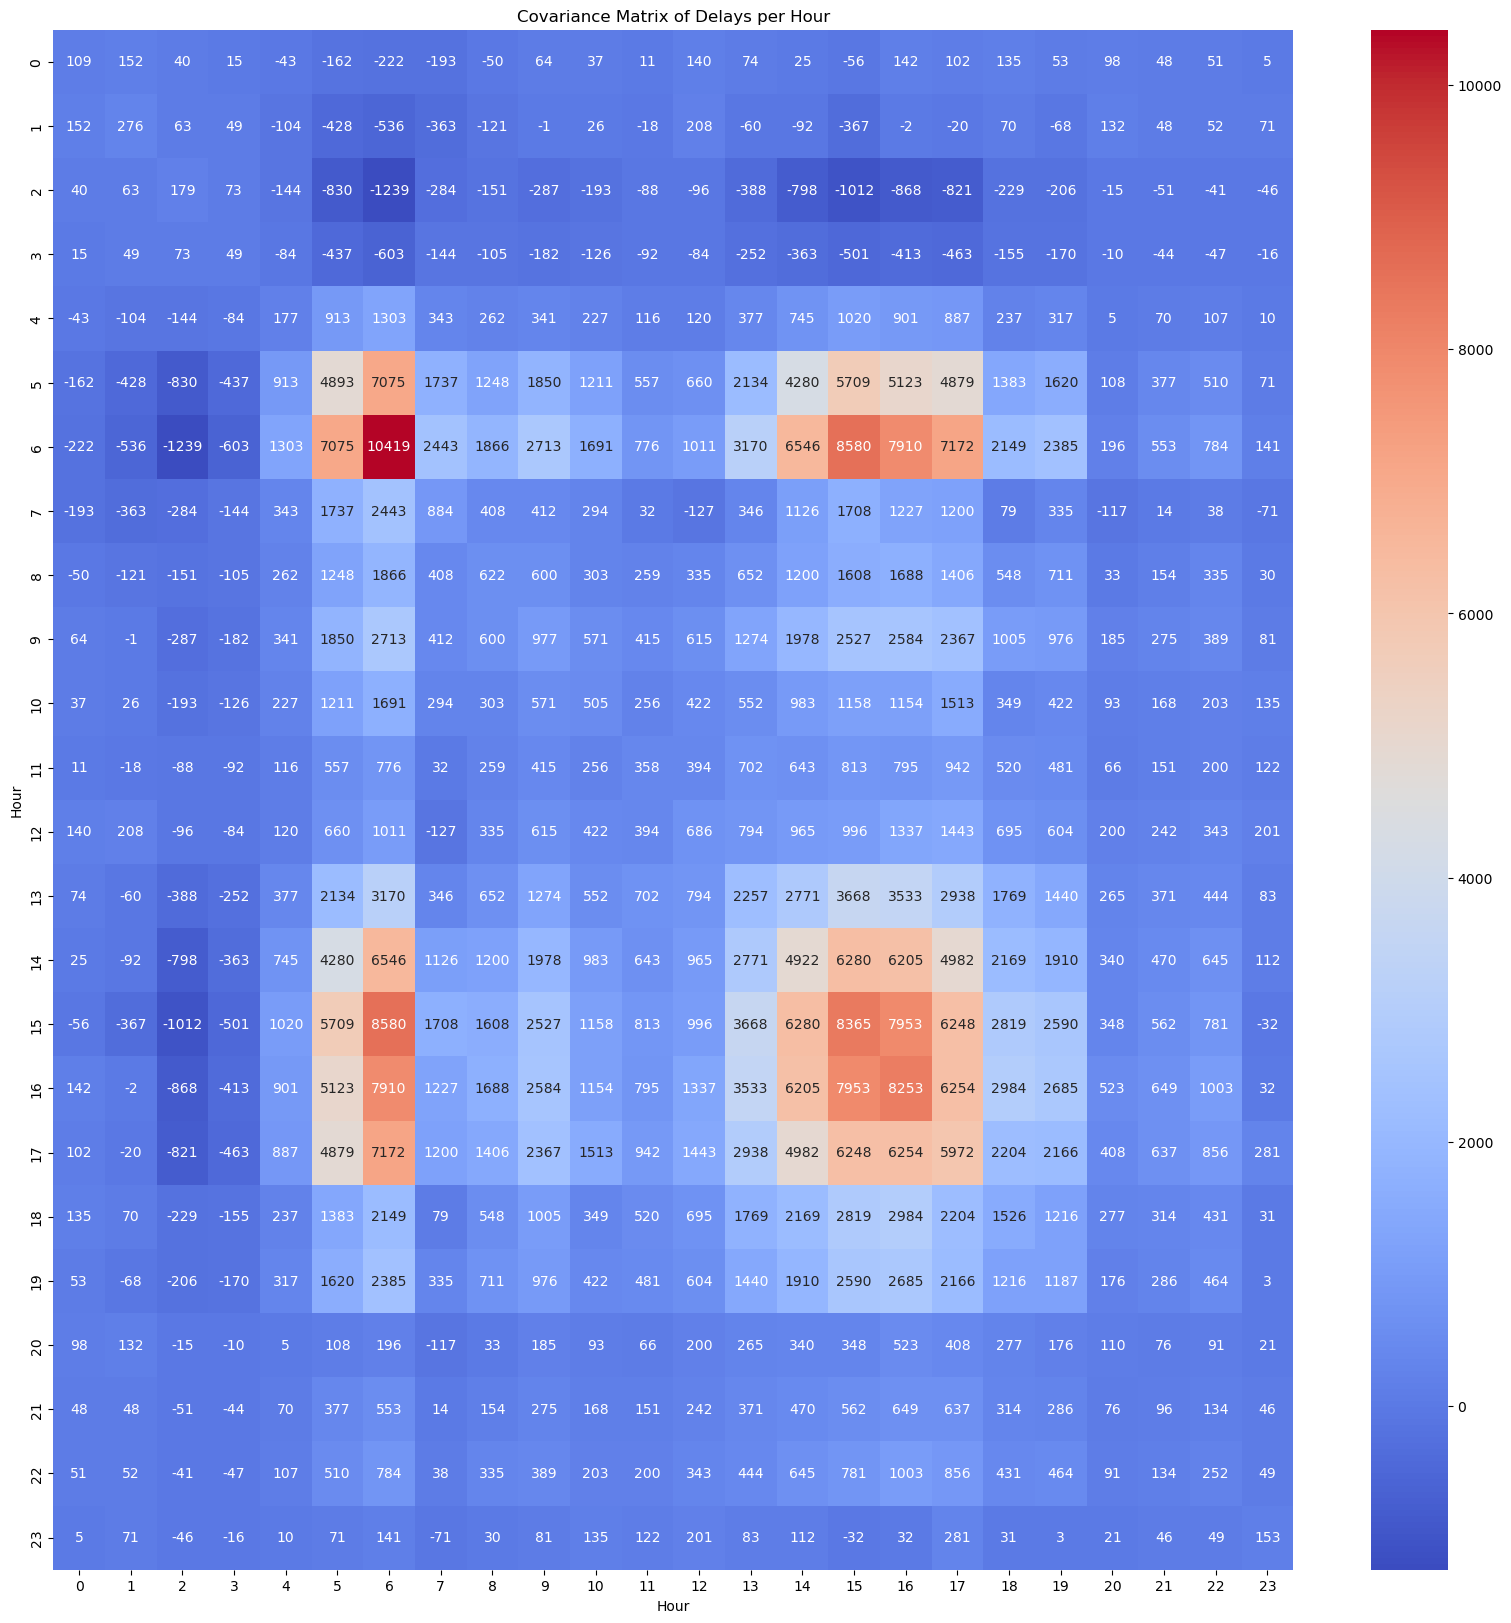

In [268]:
plt.figure(figsize=(20,20))
sns.heatmap(delays_per_hour_transposed_cov, annot=True, fmt='.0f', cmap='coolwarm')
plt.title('Covariance Matrix of Delays per Hour')

Now looking at the covariance matrix between hours of the day, it is clear that most hours have a weak relationship. There are, however, some hours that have a notably strong relationship, such as 2PM and 6AM. Further analysis is required, likely with other variables under consideration, to explore the instances and potential contributions to strong relationships.

We can explore the correlation to better understand the strength and direction of the relationship between two variables.

In [269]:
# Now, use statistical analysis to explore the correlation
# of the dataset

# delays_per_hour.reset_index(inplace=True)

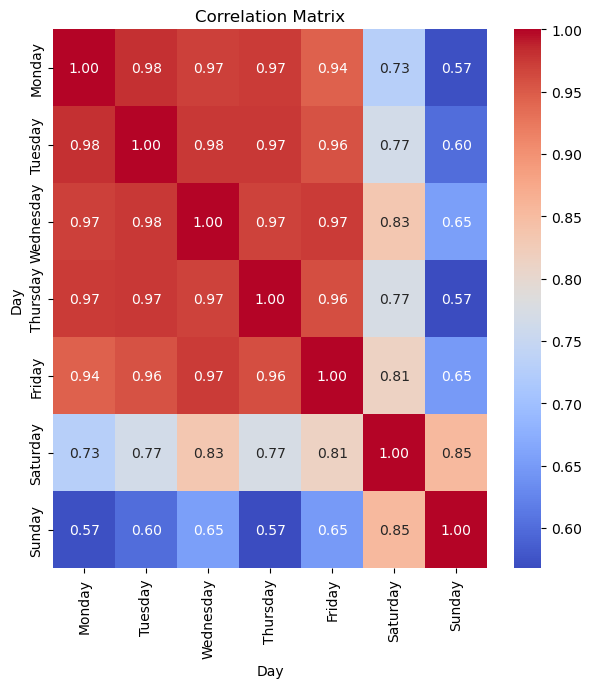

In [424]:
delays_per_hour_cor = delays_per_hour.corr()
# print(delays_per_hour_cor)

plt.figure(figsize=(7, 7))
sns.heatmap(delays_per_hour_cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The above correlation matrix shows that for each weekday, since the correlation coeffiecients are very close to 1, there is a very strong positive linear relationship. This means that, for example, as the number of delays increase on Mondays, the number of delays tends to also increase on Tuesdays. It is important to caveat, however, that this does not indicate causation. Further analysis of other variables would be required to come to a reasoning behind this strong positive linear relationship.

The opposite is true for weekends, which show a positive, but not as strong, linear relationship between number of delays on a weekend and that on a week day.

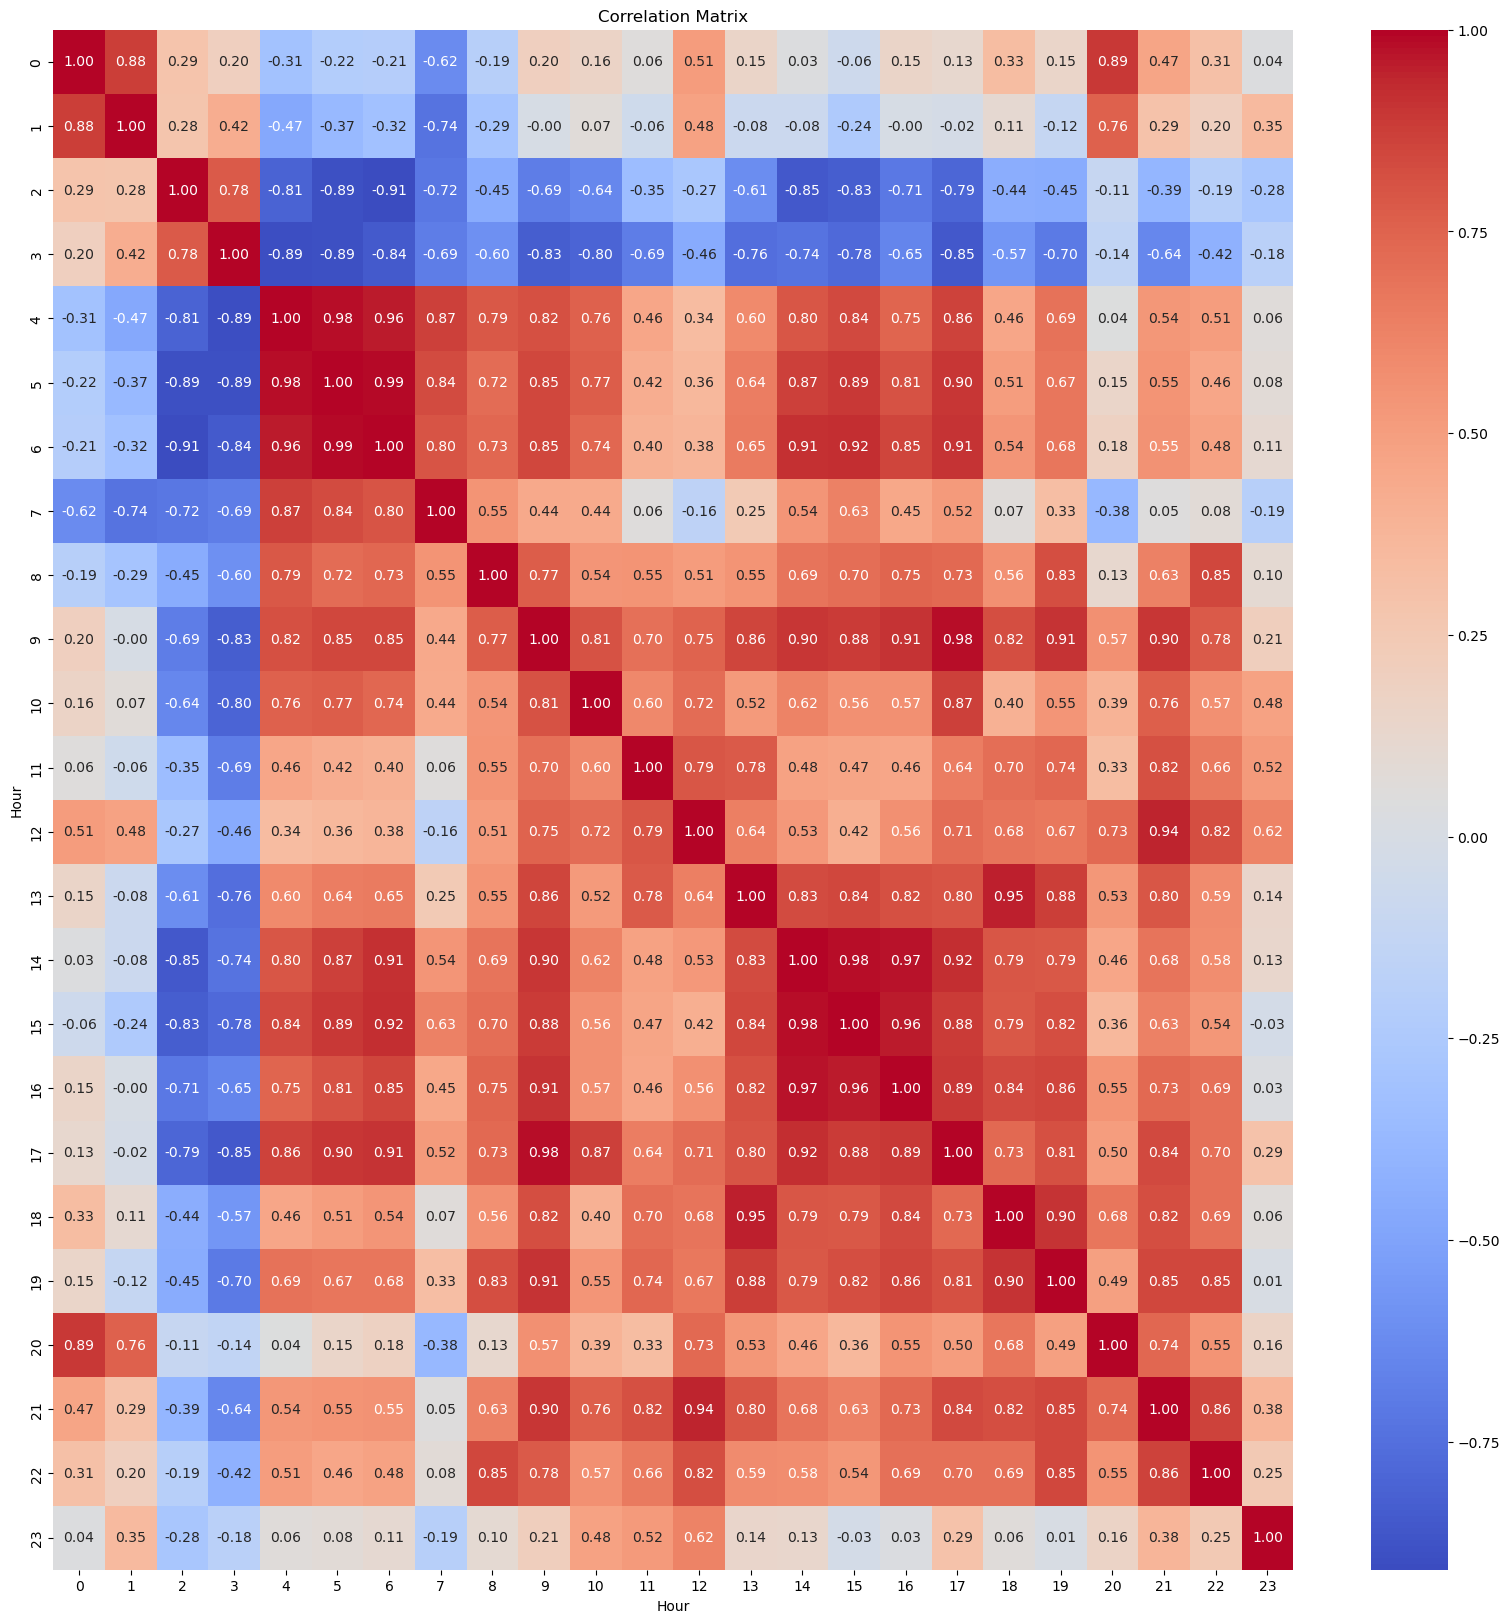

In [422]:
delays_per_hour_transposed = delays_per_hour.transpose()
delays_per_hour_transposed_cor = delays_per_hour_transposed.corr()
# print(delays_per_hour_transposed_cor)

plt.figure(figsize=(20, 20))
sns.heatmap(delays_per_hour_transposed_cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix for hours of the day show many strong, positive linear relationship. This could indicate that delays in one hour could potential cause a domino effect of delays in subsequent hours (e.g. "bus bunching"), as shown in the correlation coefficients between 2PM - 5PM - the range of highest count of delays per hour as noted in the previous observations.

## Data Modelling

To explore modelling, a simple polynomial regression model will be used to represent and predict the number of delays on a Friday throughout the year:

In [417]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

delays_per_hour_values = delays_per_hour.index.values
delays_on_fri_values = delays_per_hour['Friday'].values

# fit the polynomial regression
degree = 5 # adjust for fitting
coeffs = np.polynomial.polynomial.polyfit(delays_per_hour_values, delays_on_fri_values, degree)

x_values = delays_per_hour.index.values
y_values = np.polynomial.polynomial.polyval(x_values, coeffs)

R2 value of the training set is 0.6093152168189535
R2 value of the test set is 0.7234100417020101


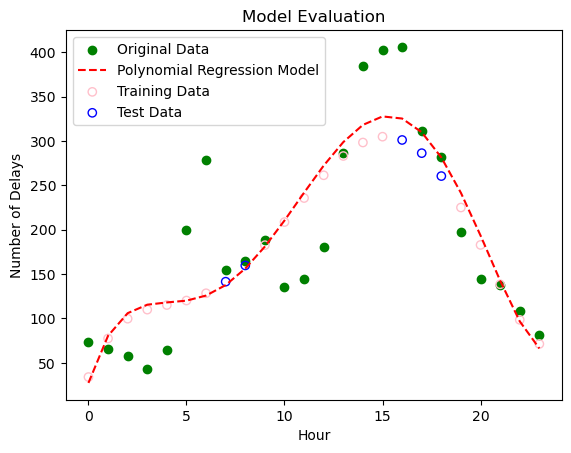

In [427]:
# split the dataset into test data and training data
X_train, X_test, y_train, y_test = train_test_split(delays_per_hour_values, delays_on_fri_values, test_size=0.2)

coeffs = np.polynomial.polynomial.polyfit(X_train, y_train, degree)

poly_values_train = np.polynomial.polynomial.polyval(X_train, coeffs)
poly_values_test = np.polynomial.polynomial.polyval(X_test, coeffs)

# clculate R-squared for the training and test sets
r2_train = r2_score(y_train, poly_values_train)
r2_test = r2_score(y_test, poly_values_test)

# # calculate MSE
# mae_train = mean_absolute_error(y_train, poly_values_train)
# mae_test = mean_absolute_error(y_test, poly_values_test)

# # calculate RMSE
# mse_train = mean_squared_error(y_train, poly_values_train)
# mse_test = mean_squared_error(y_test, poly_values_test)
# rmse_train = np.sqrt(mse_train)
# rmse_test = np.sqrt(mse_test)

print('R2 value of the training set is', r2_train)
print('R2 value of the test set is', r2_test)
# print('MAE value of the training set is', mae_train)
# print('MAE value of the test set is', mae_test)
# print('RMSE value of the training set is', rmse_train)
# print('RMSE value of the test set is', rmse_test)

# plot the model, real data, and training/test data
plt.scatter(delays_per_hour_values, delays_on_fri_values, color='green',label='Original Data')
plt.plot(x_values, y_values, linestyle='dashed', color='red', label='Polynomial Regression Model')
plt.scatter(X_train, poly_values_train, marker='o', facecolor='none', edgecolor='pink', label='Training Data')
plt.scatter(X_test, poly_values_test, marker='o', facecolor='none', edgecolor='blue', label='Test Data')

plt.xlabel('Hour')
plt.ylabel('Number of Delays')
plt.title('Model Evaluation')

plt.legend()
plt.show()

## Model Observations

The selected cost function (R2) is 0.61 for the training set and 0.72 for the test set, showing a relatively sufficient level of fitness for the model (e.g. 61% of the variance in delays per hour is accounted in the model with training data, while 72% of the variance in delays per hour on Fridays throughout the year is accounted by the model when inputting new data). This could be improved, however, with further tuning of the selected polynomial degree, feature engineering to explore other variables contributing to number of delays per hour, or investigating the validity of other regression models and techniques. The dataset could also be further enriched by using datasets containing bus delays throughout years prior to 2022.

## Recommendations

1. Take advantage of the enriched dataset and add other features/variables to the model. For example, can include, with the number of delays per hour per day, the cause of the delay, the model and engine of the fleet, etc. 
2. Explore other regression techniques/models to better fit the data.
3. Merge with a dataset with a schedule and variables indicating not_delay to explore time-series modelling and forecasting for delays.